In [7]:
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.constants import h, c

from synphot import SourceSpectrum, Observation

from matplotlib import pyplot as plt

import numpy as np
from specutils import Spectrum1D


import uvex_etc as uvex
from uvex_etc import zodi, galactic, lyman,config, filters

# Imaging bandpasses
nuv_band = uvex.filters.nuv_bandpass()
fuv_band = uvex.filters.fuv_bandpass()

UVEX = config.UVEX()


# Convenience
area = UVEX.AREA

# Spectrometer bins and bandpass
spec_bins = filters.lss_wave()
spec_band = filters.lss_bandpass()

spec_bins.min()

<Quantity 1150.368 Angstrom>

In [8]:
phlam = (u.ph / u.cm**2 / u.s / u.AA)

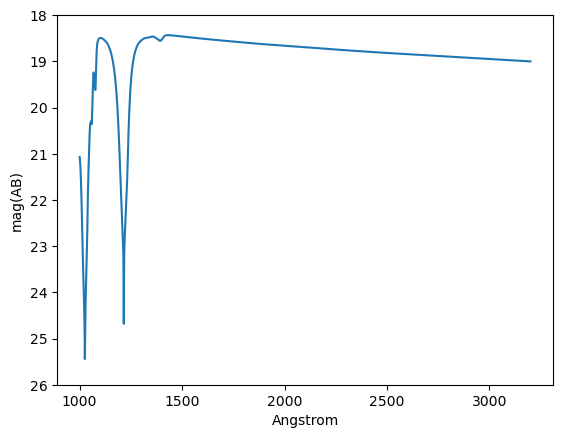

In [9]:
# Preprocess model
# Your model will vary here

data = np.genfromtxt('example_data/wd_afgk_2.dat', skip_header=3)
wave = data[:, 0] * u.AA
flux = data[:, 1] 

ab_flux = (flux)*(u.ABmag)

ax = plt.figure().subplots()
ax.plot(wave, ab_flux)
ax.set_ylabel(ab_flux.unit)
ax.set_xlabel(wave.unit)
ax.set_ylim(26, 18)
plt.show()


In [10]:
ph_flux = ab_flux.to((u.ph / u.cm**2 / u.s / u.AA), equivalencies=u.spectral_density(wave))

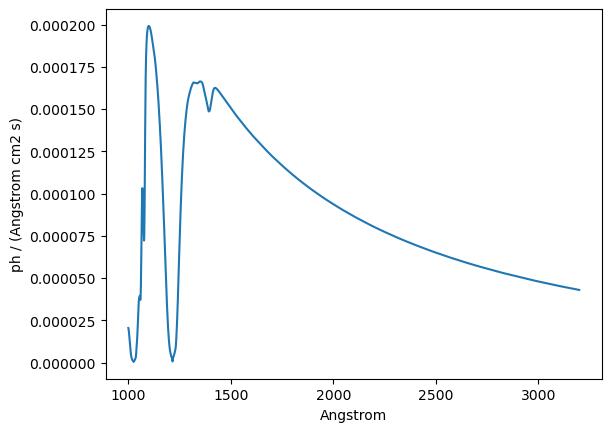

In [11]:
# Convert this to a Spectrum1D model
model = Spectrum1D(flux=ph_flux, spectral_axis= wave)

ax = plt.figure().subplots()
ax.plot(wave, ph_flux)
ax.set_ylabel(ph_flux.unit)
ax.set_xlabel(wave.unit)
plt.show()

In [12]:
# Load backgrounds

# Pick some random field
#         "Samwell": {"ra": 197.6898587, 
#                    "dec": 8.5678292},
ra = 197.6898587
dec = 8.5678292

# Pic an observation date
obstime = Time('2021-06-10 09:00:00')

# Create SkyCoord object, coords in GeocentricTrueEcliptic frame
coord = SkyCoord(ra*u.deg,
                  dec*u.deg,
                  obstime=obstime, frame='icrs').transform_to("geocentrictrueecliptic")
gal = coord.galactic
radec = coord.icrs
print(f'Galactic latitude: {gal.b:8.2f}')

Galactic latitude:    70.88 deg


In [14]:
# Statistics for the NUV band
band = 'NUV'

galactic_spec = galactic.galactic_nuv_spec(gal.b)
print(band)
print()
zodi_spec = zodi.zodi_spec_coords(radec, obstime, diag=True)

# Create observations
nuv_zodi = Observation(zodi_spec, nuv_band)
nuv_galactic = Observation(galactic_spec, nuv_band)

sky = nuv_zodi.countrate(area=area) + nuv_galactic.countrate(area=area)
obs_nuv = Observation(model, nuv_band, force='extrap')
source = obs_nuv.countrate(area=area)
dt = uvex.get_exposure(source, sky)

print()
print(f'Flux density: {obs_nuv.effstim(u.ABmag):8.2f}')
print(f'Estimated count rate: {source:8.2f}')
print(f'Sky count rate: {sky:8.2e}')
print(f'Time to achieve 5-sigma {dt:8.2f} (sec)')


NUV

zodi_spec_coords:
Ecliptic lat/lon:    14.85 /   113.53
Zodi scale: [161.45352542]

Flux density:    18.76 mag(AB)
Estimated count rate:    25.58 ct / s
Sky count rate: 9.57e-03 ct / s
Time to achieve 5-sigma     1.83 (sec)


In [15]:
# Statitics for the FUV band
band = 'FUV'

galactic_spec = galactic.galactic_fuv_spec(gal.b)
print(band)
print()
zodi_spec = zodi.zodi_spec_coords(radec, obstime, diag=True)


# Create observations
fuv_zodi = Observation(zodi_spec, fuv_band, force = 'extrap')
fuv_galactic = Observation(galactic_spec, fuv_band, force = 'extrap')

sky = fuv_zodi.countrate(area=area) + fuv_galactic.countrate(area=area)


obs_fuv = Observation(model, fuv_band, force='extrap')
source = obs_fuv.countrate(area=area)
dt = uvex.get_exposure(source, sky)

print()
print(f'Flux density: {obs_fuv.effstim(u.ABmag):8.2f}')
print(f'Estimated count rate: {source:8.2f}')
print(f'Sky count rate: {sky:8.2e}')
print(f'Time to achieve 5-sigma {dt:8.2f} (sec)')

FUV

zodi_spec_coords:
Ecliptic lat/lon:    14.85 /   113.53
Zodi scale: [161.45352542]

Flux density:    18.52 mag(AB)
Estimated count rate:    20.88 ct / s
Sky count rate: 9.42e-04 ct / s
Time to achieve 5-sigma     2.24 (sec)


# Spectrometer Example

In [16]:
# Spectrometer, using specutils:
# Build the observation and get binned counts per second sampled at the spectrometer pixel locations
obs = Observation(model, spec_band, binset=spec_bins, force='extrap')
binflux = obs.sample_binned(flux_unit='count', area=area) 
# Let 1 hour be the exposure time and see what the expected number of counts per pixel is:

exposure = 3600*u.s
ctsflux = binflux * exposure




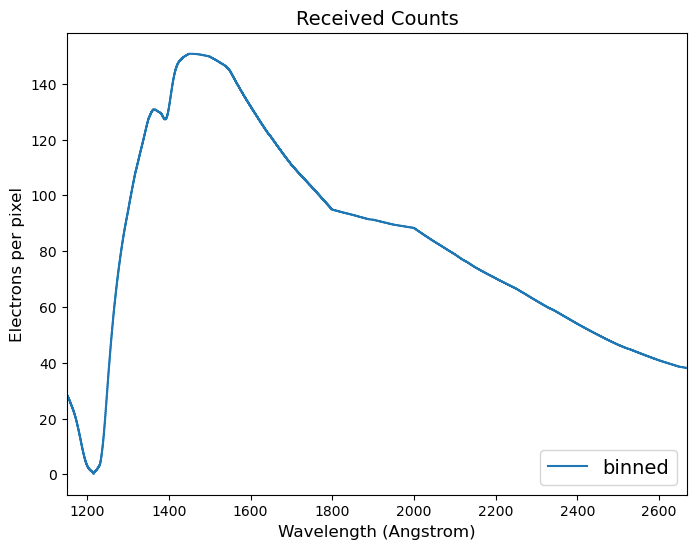

In [17]:
# Expected counts per pixel after 


# Expected counts per pixel after 



# Plot results
ax = plt.figure(figsize=(8, 6)).subplots()


ax.plot(spec_bins, ctsflux, drawstyle='steps-mid', label='binned')
ax.set_xlabel('Wavelength (Angstrom)', fontsize=12)
ax.set_ylabel('Electrons per pixel', fontsize=12)
ax.legend(loc='lower right', numpoints=1, fontsize=14)
ax.set_xlim(spec_bins.min().value, spec_bins.max().value)
ax.set_title('Received Counts', fontsize=14)
plt.show()

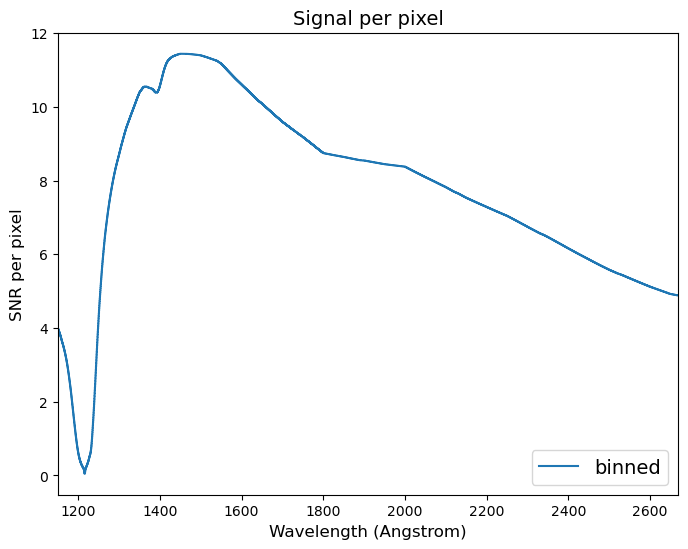

In [19]:
# Estimate the SNR per pixel

sky = 0 * binflux.unit # Set the sky background to zero here

snr = uvex.get_snr(exposure,binflux,sky,npix=3)

ax = plt.figure(figsize=(8, 6)).subplots()
ax.plot(spec_bins, snr, drawstyle='steps-mid', label='binned')
ax.set_xlabel('Wavelength (Angstrom)', fontsize=12)
ax.set_ylabel('SNR per pixel', fontsize=12)
ax.legend(loc='lower right', numpoints=1, fontsize=14)
ax.set_xlim(spec_bins.min().value, spec_bins.max().value)
ax.set_title('Signal per pixel', fontsize=14)
plt.show()

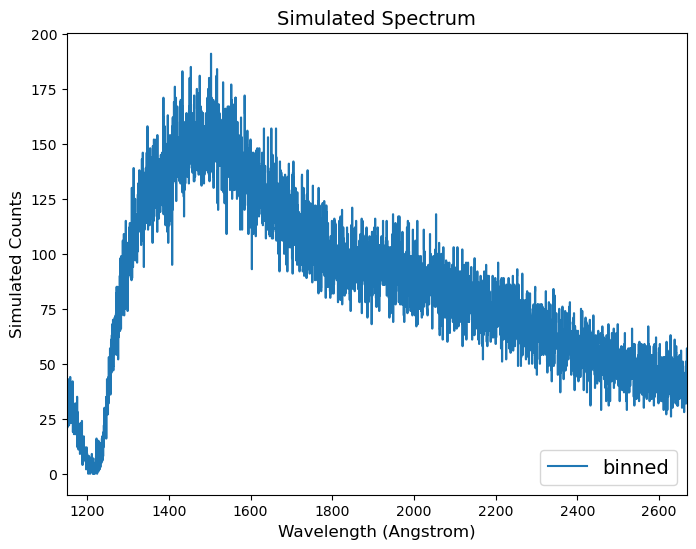

In [21]:
# Look at what an actual spectrum would look like
countspec = filters.make_lss_spectrum(binflux.value, exposure = exposure)
ax = plt.figure(figsize=(8, 6)).subplots()
ax.plot(spec_bins, countspec, drawstyle='steps-mid', label='binned')
ax.set_xlabel('Wavelength (Angstrom)', fontsize=12)
ax.set_ylabel('Simulated Counts', fontsize=12)
ax.legend(loc='lower right', numpoints=1, fontsize=14)
ax.set_xlim(spec_bins.min().value, spec_bins.max().value)
ax.set_title('Simulated Spectrum', fontsize=14)
plt.show()